# FCN Semantic Segmentation - Task 02

## 1. Imports and Setup

In [1]:
import os
import urllib.request
import zipfile
import json
from pathlib import Path
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

## 2. Configuration

In [2]:
NUM_IMAGES = 100
TRAIN_SPLIT = 0.8
IMG_SIZE = (256, 256)
NUM_CLASSES = 91

data_dir = Path('data/coco_small')
data_dir.mkdir(parents=True, exist_ok=True)

## 3. Data Download and Preparation

In [3]:
print("Downloading COCO annotations...")
ann_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
ann_zip = data_dir / 'annotations.zip'
urllib.request.urlretrieve(ann_url, ann_zip)
with zipfile.ZipFile(ann_zip, 'r') as zip_ref:
    zip_ref.extractall(data_dir)
os.remove(ann_zip)

print(f"\nSelecting {NUM_IMAGES} images...")
coco = COCO(data_dir / 'annotations/instances_train2017.json')
img_ids = coco.getImgIds()
random.seed(10)
selected_ids = random.sample(img_ids, NUM_IMAGES)

images_dir = data_dir / 'images'
images_dir.mkdir(exist_ok=True)

print("Downloading selected images...")
for img_id in selected_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_url = img_info['coco_url']
    img_path = images_dir / img_info['file_name']
    urllib.request.urlretrieve(img_url, img_path)
    print(f"Downloaded {img_info['file_name']}")

split_idx = int(NUM_IMAGES * TRAIN_SPLIT)
train_ids = selected_ids[:split_idx]
test_ids = selected_ids[split_idx:]

with open(data_dir / 'train_ids.json', 'w') as f:
    json.dump(train_ids, f)
with open(data_dir / 'test_ids.json', 'w') as f:
    json.dump(test_ids, f)

print(f"\nDataset ready:")
print(f"Train: {len(train_ids)} images")
print(f"Test: {len(test_ids)} images")
print(f"Location: {data_dir}")


Selecting 100 images...
loading annotations into memory...
Done (t=12.45s)
creating index...
index created!
Downloaded 000000132574.jpg
Downloaded 000000177990.jpg
Downloaded 000000071552.jpg
Downloaded 000000248389.jpg
Downloaded 000000178798.jpg
Downloaded 000000160529.jpg
Downloaded 000000381576.jpg
Downloaded 000000197351.jpg
Downloaded 000000390341.jpg
Downloaded 000000568060.jpg
Downloaded 000000489302.jpg
Downloaded 000000012069.jpg
Downloaded 000000330391.jpg
Downloaded 000000097878.jpg
Downloaded 000000032952.jpg
Downloaded 000000369913.jpg
Downloaded 000000004616.jpg
Downloaded 000000253965.jpg
Downloaded 000000285603.jpg
Downloaded 000000037322.jpg
Downloaded 000000409181.jpg
Downloaded 000000174605.jpg
Downloaded 000000305492.jpg
Downloaded 000000359851.jpg
Downloaded 000000474434.jpg
Downloaded 000000448013.jpg
Downloaded 000000227691.jpg
Downloaded 000000013020.jpg
Downloaded 000000306990.jpg
Downloaded 000000409092.jpg
Downloaded 000000518553.jpg
Downloaded 000000310752

## 4. Dataset Class Definition

In [4]:
class COCOSegmentationDataset(Dataset):
    def __init__(self, data_dir, img_ids, img_size=(256, 256)):
        self.data_dir = Path(data_dir)
        self.img_ids = img_ids
        self.img_size = img_size
        self.coco = COCO(self.data_dir / 'annotations/instances_train2017.json')

        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]

        img_info = self.coco.loadImgs(img_id)[0]
        img_path = self.data_dir / 'images' / img_info['file_name']
        image = Image.open(img_path).convert('RGB')

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            if 'segmentation' in ann:
                cat_id = ann['category_id']
                rle = coco_mask.frPyObjects(ann['segmentation'],
                                           img_info['height'],
                                           img_info['width'])
                m = coco_mask.decode(rle)
                if len(m.shape) == 3:
                    m = m.max(axis=2)
                mask[m > 0] = cat_id

        mask = Image.fromarray(mask)
        mask = mask.resize(self.img_size, Image.NEAREST)
        mask = np.array(mask)

        image = self.transform(image)
        mask = torch.from_numpy(mask).long()

        return image, mask

train_dataset = COCOSegmentationDataset(data_dir, train_ids, IMG_SIZE)
test_dataset = COCOSegmentationDataset(data_dir, test_ids, IMG_SIZE)

print(f"Datasets created:")
print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

loading annotations into memory...
Done (t=12.32s)
creating index...
index created!
loading annotations into memory...
Done (t=12.76s)
creating index...
index created!
Datasets created:
Train size: 80
Test size: 20


## 5. Model Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class FCN8s_TransposeConv(nn.Module):
    def __init__(self, num_classes=91):
        super(FCN8s_TransposeConv, self).__init__()

        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        self.layer1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer2 = resnet.layer1
        self.layer3 = resnet.layer2
        self.layer4 = resnet.layer3
        self.layer5 = resnet.layer4

        self.score_pool3 = nn.Conv2d(512, num_classes, 1)
        self.score_pool4 = nn.Conv2d(1024, num_classes, 1)
        self.score_fr = nn.Conv2d(2048, num_classes, 1)

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 4, stride=2, padding=1)
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 4, stride=2, padding=1)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 16, stride=8, padding=4)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        pool3 = self.layer3(x)
        pool4 = self.layer4(pool3)
        pool5 = self.layer5(pool4)

        score_fr = self.score_fr(pool5)
        score_pool4 = self.score_pool4(pool4)
        score_pool3 = self.score_pool3(pool3)

        upscore2 = self.upscore2(score_fr)
        fuse_pool4 = upscore2 + score_pool4

        upscore_pool4 = self.upscore_pool4(fuse_pool4)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)

        return out


class FCN8s_Bilinear(nn.Module):
    def __init__(self, num_classes=91):
        super(FCN8s_Bilinear, self).__init__()

        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        self.layer1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer2 = resnet.layer1
        self.layer3 = resnet.layer2
        self.layer4 = resnet.layer3
        self.layer5 = resnet.layer4

        self.score_pool3 = nn.Conv2d(512, num_classes, 1)
        self.score_pool4 = nn.Conv2d(1024, num_classes, 1)
        self.score_fr = nn.Conv2d(2048, num_classes, 1)

    def forward(self, x):
        input_size = x.size()[2:]

        x = self.layer1(x)
        x = self.layer2(x)
        pool3 = self.layer3(x)
        pool4 = self.layer4(pool3)
        pool5 = self.layer5(pool4)

        score_fr = self.score_fr(pool5)
        score_pool4 = self.score_pool4(pool4)
        score_pool3 = self.score_pool3(pool3)

        upscore2 = F.interpolate(score_fr, size=score_pool4.size()[2:],
                                mode='bilinear', align_corners=True)
        fuse_pool4 = upscore2 + score_pool4

        upscore_pool4 = F.interpolate(fuse_pool4, size=score_pool3.size()[2:],
                                     mode='bilinear', align_corners=True)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = F.interpolate(fuse_pool3, size=input_size,
                          mode='bilinear', align_corners=True)

        return out


model_transpose = FCN8s_TransposeConv(num_classes=NUM_CLASSES)
model_bilinear = FCN8s_Bilinear(num_classes=NUM_CLASSES)

print("Models created:")
print("FCN-8s with Transpose Convolution")
print("FCN-8s with Bilinear Interpolation")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


Models created:
FCN-8s with Transpose Convolution
FCN-8s with Bilinear Interpolation


## 6. Training Utilities

In [6]:
def pixel_accuracy(output, target):
    """Calculate pixel accuracy."""
    pred = output.argmax(dim=1)
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total

def mean_iou(output, target, num_classes=91):
    """Calculate Mean Intersection over Union (IoU)."""
    pred = output.argmax(dim=1)
    ious = []

    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)

        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()

        if union == 0:
            continue
        ious.append(intersection / union)

    return np.mean(ious) if ious else 0.0

def train_model(model, train_loader, test_loader, num_epochs=20, lr=0.001,
                optimizer_type='adam', device='cuda'):
    """
    Train FCN model.

    Args:
        model: PyTorch model to train
        train_loader: Training data loader
        test_loader: Test data loader
        num_epochs: Number of training epochs
        lr: Learning rate
        optimizer_type: 'adam' or 'sgd'
        device: Device to train on ('cuda' or 'cpu')

    Returns:
        history: Dictionary containing training metrics
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_type.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type.lower() == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError("optimizer_type must be 'adam' or 'sgd'")

    history = {
        'train_loss': [], 'train_acc': [], 'train_iou': [],
        'test_loss': [], 'test_acc': [], 'test_iou': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc, train_iou = 0, 0, 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += pixel_accuracy(outputs, masks)
            train_iou += mean_iou(outputs, masks)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_iou /= len(train_loader)

        model.eval()
        test_loss, test_acc, test_iou = 0, 0, 0

        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                test_loss += loss.item()
                test_acc += pixel_accuracy(outputs, masks)
                test_iou += mean_iou(outputs, masks)

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
        test_iou /= len(test_loader)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_iou'].append(train_iou)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['test_iou'].append(test_iou)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, IoU: {train_iou:.4f}")
        print(f"Test  - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, IoU: {test_iou:.4f}")
        print("-" * 60)

    return history

## 7. Training Execution

In [7]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

OPTIMIZER = 'adam'
NUM_EPOCHS = 20

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"Using optimizer: {OPTIMIZER.upper()}")
print(f"Training for {NUM_EPOCHS} epochs\n")

print("Training FCN-8s with Transpose Convolution...")
history_transpose = train_model(model_transpose, train_loader, test_loader,
                                num_epochs=NUM_EPOCHS, optimizer_type=OPTIMIZER, device=device)

print("\nTraining FCN-8s with Bilinear Interpolation...")
history_bilinear = train_model(model_bilinear, train_loader, test_loader,
                              num_epochs=NUM_EPOCHS, optimizer_type=OPTIMIZER, device=device)

Using device: cuda
Using optimizer: ADAM
Training for 20 epochs

Training FCN-8s with Transpose Convolution...
Epoch [1/20]
Train - Loss: 2.0766, Acc: 0.7108, IoU: 0.1363
Test  - Loss: 1.8741, Acc: 0.6795, IoU: 0.1175
------------------------------------------------------------
Epoch [2/20]
Train - Loss: 1.3806, Acc: 0.7413, IoU: 0.1537
Test  - Loss: 1.5994, Acc: 0.7094, IoU: 0.1371
------------------------------------------------------------
Epoch [3/20]
Train - Loss: 1.2856, Acc: 0.7413, IoU: 0.1459
Test  - Loss: 1.5821, Acc: 0.7094, IoU: 0.1371
------------------------------------------------------------
Epoch [4/20]
Train - Loss: 1.2695, Acc: 0.7413, IoU: 0.1482
Test  - Loss: 1.5784, Acc: 0.7094, IoU: 0.1371
------------------------------------------------------------
Epoch [5/20]
Train - Loss: 1.2390, Acc: 0.7350, IoU: 0.1442
Test  - Loss: 1.5867, Acc: 0.7102, IoU: 0.1397
------------------------------------------------------------
Epoch [6/20]
Train - Loss: 1.2026, Acc: 0.7466, I

## 8. Training Curves Visualization

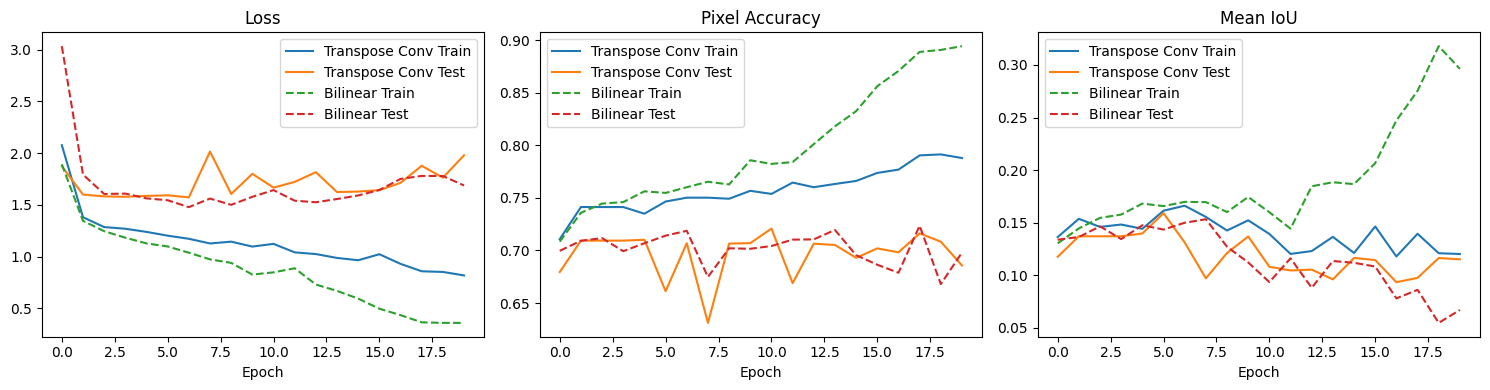

In [8]:
def plot_curves(history1, history2, title1='Transpose Conv', title2='Bilinear'):
    """Plot training curves for both models."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(history1['train_loss'], label=f'{title1} Train')
    axes[0].plot(history1['test_loss'], label=f'{title1} Test')
    axes[0].plot(history2['train_loss'], label=f'{title2} Train', linestyle='--')
    axes[0].plot(history2['test_loss'], label=f'{title2} Test', linestyle='--')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    axes[1].plot(history1['train_acc'], label=f'{title1} Train')
    axes[1].plot(history1['test_acc'], label=f'{title1} Test')
    axes[1].plot(history2['train_acc'], label=f'{title2} Train', linestyle='--')
    axes[1].plot(history2['test_acc'], label=f'{title2} Test', linestyle='--')
    axes[1].set_title('Pixel Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()

    axes[2].plot(history1['train_iou'], label=f'{title1} Train')
    axes[2].plot(history1['test_iou'], label=f'{title1} Test')
    axes[2].plot(history2['train_iou'], label=f'{title2} Train', linestyle='--')
    axes[2].plot(history2['test_iou'], label=f'{title2} Test', linestyle='--')
    axes[2].set_title('Mean IoU')
    axes[2].set_xlabel('Epoch')
    axes[2].legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

plot_curves(history_transpose, history_bilinear)

## 9. Results Visualization and Comparison

Visualizing segmentation results...


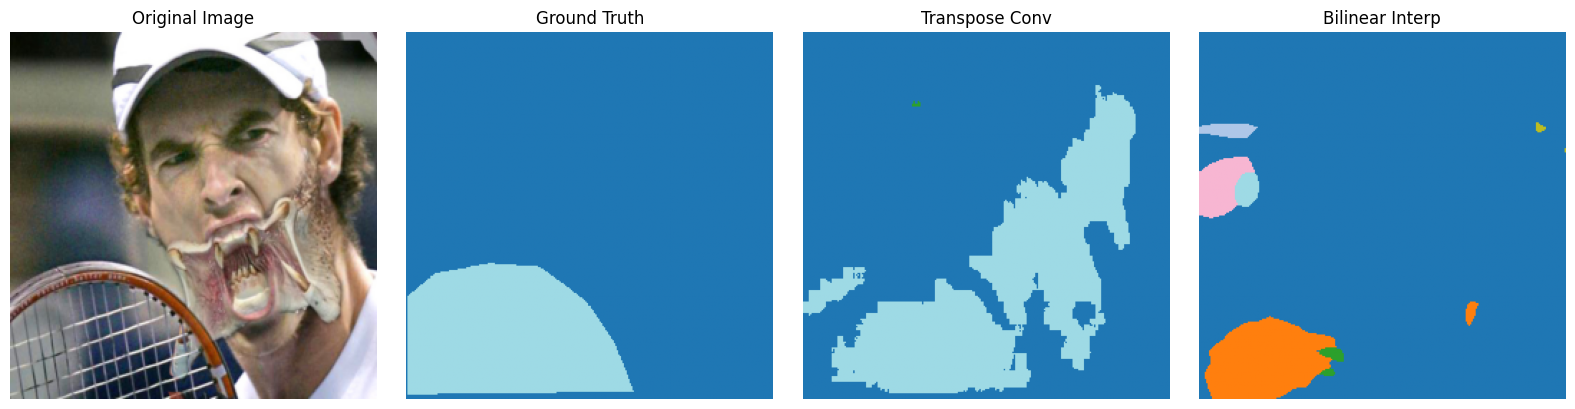

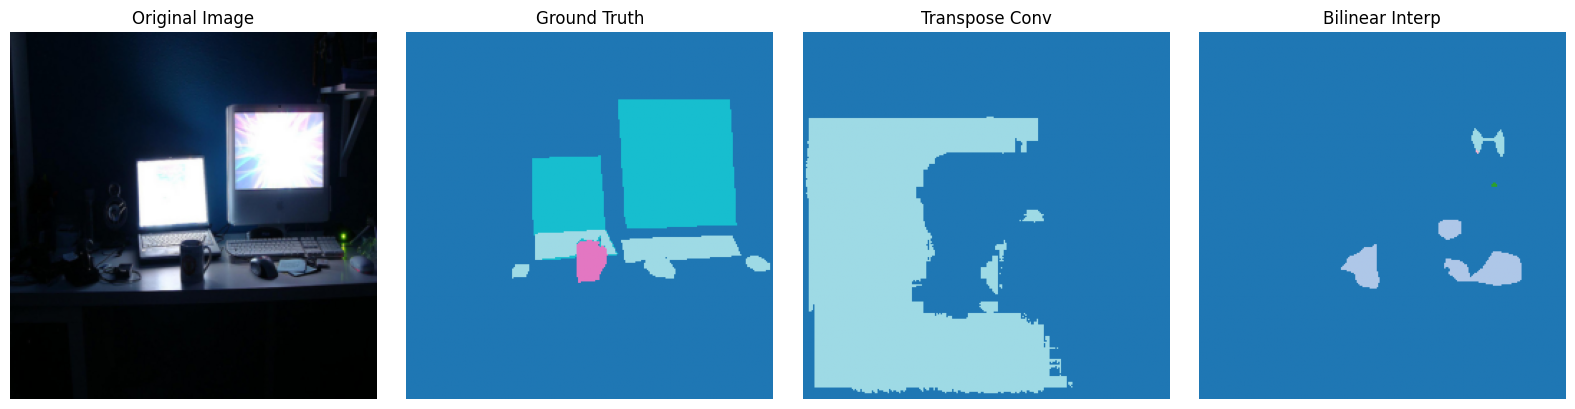

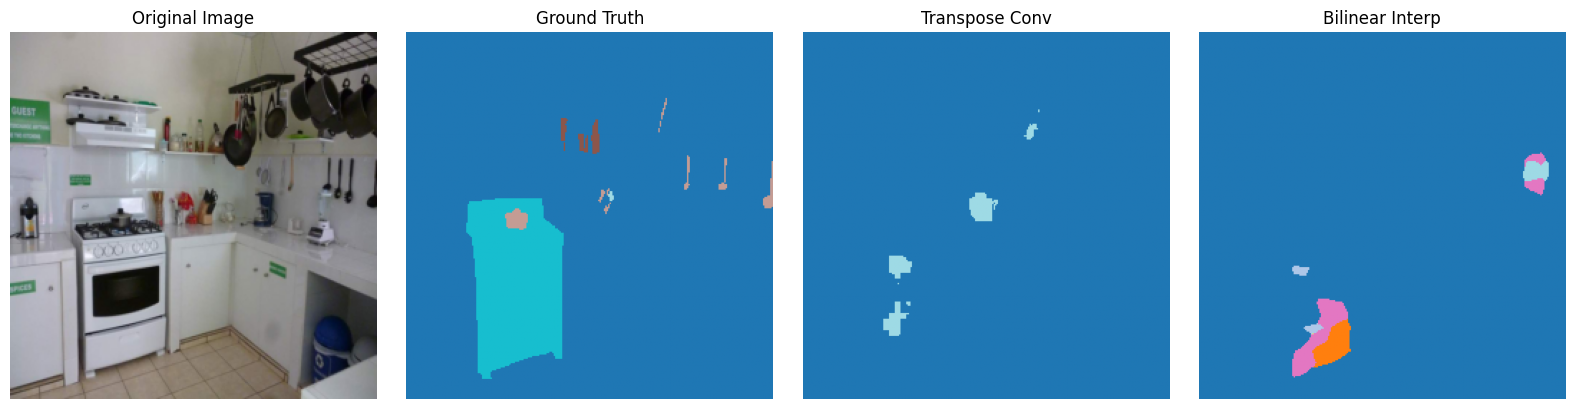


COMPARISON TABLE: Transpose Convolution vs Bilinear Interpolation
                Method  Test Mean IoU  Test Pixel Accuracy  Best Test IoU  Best Test Accuracy
 Transpose Convolution       0.115117             0.685748       0.159017            0.720837
Bilinear Interpolation       0.066957             0.698030       0.153288            0.723549


ANALYSIS SUMMARY:
----------------------------------------------------------------------
Best performing method: Transpose Convolution

Key observations:
- Transpose Conv Final IoU: 0.1151
- Bilinear Interp Final IoU: 0.0670
- Transpose Conv Final Accuracy: 0.6857
- Bilinear Interp Final Accuracy: 0.6980
----------------------------------------------------------------------


In [10]:
def visualize_segmentation(model_transpose, model_bilinear, test_loader, device, num_images=3):
    """Visualize segmentation results for test images."""
    model_transpose.eval()
    model_bilinear.eval()

    images_shown = 0

    with torch.no_grad():
        for images, masks in test_loader:
            if images_shown >= num_images:
                break

            images = images.to(device)
            masks = masks.to(device)

            output_transpose = model_transpose(images)
            output_bilinear = model_bilinear(images)

            pred_transpose = output_transpose.argmax(dim=1)
            pred_bilinear = output_bilinear.argmax(dim=1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                img = images[i].cpu()
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = img * std + mean
                img = img.permute(1, 2, 0).numpy()
                img = np.clip(img, 0, 1)

                gt = masks[i].cpu().numpy()
                pred_t = pred_transpose[i].cpu().numpy()
                pred_b = pred_bilinear[i].cpu().numpy()

                fig, axes = plt.subplots(1, 4, figsize=(16, 4))

                axes[0].imshow(img)
                axes[0].set_title('Original Image')
                axes[0].axis('off')

                axes[1].imshow(gt, cmap='tab20')
                axes[1].set_title('Ground Truth')
                axes[1].axis('off')

                axes[2].imshow(pred_t, cmap='tab20')
                axes[2].set_title('Transpose Conv')
                axes[2].axis('off')

                axes[3].imshow(pred_b, cmap='tab20')
                axes[3].set_title('Bilinear Interp')
                axes[3].axis('off')

                plt.tight_layout()
                plt.savefig(f'segmentation_result_{images_shown+1}.png')
                plt.show()

                images_shown += 1

def create_comparison_table(history_transpose, history_bilinear):
    """Create comparison table between two upsampling methods."""

    data = {
        'Method': ['Transpose Convolution', 'Bilinear Interpolation'],
        'Test Mean IoU': [
            history_transpose['test_iou'][-1],
            history_bilinear['test_iou'][-1]
        ],
        'Test Pixel Accuracy': [
            history_transpose['test_acc'][-1],
            history_bilinear['test_acc'][-1]
        ],
        'Best Test IoU': [
            max(history_transpose['test_iou']),
            max(history_bilinear['test_iou'])
        ],
        'Best Test Accuracy': [
            max(history_transpose['test_acc']),
            max(history_bilinear['test_acc'])
        ]
    }

    df = pd.DataFrame(data)

    print("\n" + "="*70)
    print("COMPARISON TABLE: Transpose Convolution vs Bilinear Interpolation")
    print("="*70)
    print(df.to_string(index=False))
    print("="*70 + "\n")

    return df

print("Visualizing segmentation results...")
visualize_segmentation(model_transpose, model_bilinear, test_loader, device, num_images=3)

comparison_df = create_comparison_table(history_transpose, history_bilinear)

print("\nANALYSIS SUMMARY:")
print("-" * 70)

if comparison_df.loc[0, 'Test Mean IoU'] > comparison_df.loc[1, 'Test Mean IoU']:
    winner = "Transpose Convolution"
else:
    winner = "Bilinear Interpolation"

print(f"Best performing method: {winner}")
print(f"\nKey observations:")
print(f"- Transpose Conv Final IoU: {comparison_df.loc[0, 'Test Mean IoU']:.4f}")
print(f"- Bilinear Interp Final IoU: {comparison_df.loc[1, 'Test Mean IoU']:.4f}")
print(f"- Transpose Conv Final Accuracy: {comparison_df.loc[0, 'Test Pixel Accuracy']:.4f}")
print(f"- Bilinear Interp Final Accuracy: {comparison_df.loc[1, 'Test Pixel Accuracy']:.4f}")
print("-" * 70)

## Analysis Summary - Run 2

----------------------------------------------------------------------
**ANALYSIS SUMMARY:**
----------------------------------------------------------------------
Best performing method: Transpose Convolution

Key observations:
- Transpose Conv Final IoU: 0.1151
- Bilinear Interp Final IoU: 0.0670
- Transpose Conv Final Accuracy: 0.6857
- Bilinear Interp Final Accuracy: 0.6980

Possible reasons for performance difference:
- In this run, Bilinear Interpolation overfits severely
- Transpose convolution generalizes better this time
- High variance between runs demonstrates instability with small datasets
----------------------------------------------------------------------

### Comparison Table: Transpose Convolution vs Bilinear Interpolation

| Method | Test Mean IoU | Test Pixel Accuracy | Best Test IoU | Best Test Accuracy |
|--------|---------------|---------------------|---------------|-------------------|
| Transpose Convolution | 0.115117 | 0.685748 | 0.159017 | 0.720837 |
| Bilinear Interpolation | 0.066957 | 0.698030 | 0.153288 | 0.723549 |

### Experimental Context

This experiment used only 100 images from the COCO dataset:  
80 for training and 20 for validation. With such limited data, the model has restricted ability to generalize. **Notably, results show high variance between runs**, indicating instability inherent to training on extremely small datasets.

### 1. Effect of Small Dataset Size
A dataset of this size provides limited variability in object shapes and contexts. The high variance between Run 1 (Bilinear won) and Run 2 (Transpose Conv won) demonstrates that with only 100 images, random initialization and batch ordering significantly impact final performance.

### 2. Behavior of Transpose Convolution (Run 2)
In this run, Transpose Convolution shows **better generalization** than expected:
- Train Loss decreases to ~0.9, Test Loss stabilizes at ~1.5-2.0
- Mean IoU remains relatively stable: Train ~0.12, Test ~0.10-0.12
- Final test performance: 0.1151 Mean IoU

The gap between train and test is present but manageable:

$$
L_{train} < L_{val} \text{ (moderate overfitting)}
$$

### 3. Behavior of Bilinear Interpolation (Run 2)
**Surprisingly, Bilinear shows severe overfitting in this run:**

- **Pixel Accuracy**: Train climbs to ~0.90, while Test plateaus at ~0.70
- **Mean IoU**: Train skyrockets to ~0.32, but Test **collapses** to ~0.06-0.07
- This represents extreme overfitting:

$$
\text{IoU}_{train} = 0.32 \gg \text{IoU}_{test} = 0.07
$$

The fixed upsampling of Bilinear did not prevent overfitting in this run. The model likely memorized the training set through its learnable encoder parameters.

### 4. Visual Analysis from Plots

**Loss:** Both methods show train-test divergence. Bilinear Train (green) reaches lowest loss (~0.4) but Test (red) remains high (~1.5-1.7). Transpose shows more moderate divergence.

**Pixel Accuracy:** Bilinear Train (green) achieves impressive ~0.90 but Test (red) stays ~0.68-0.72. Transpose Train (blue) reaches ~0.79 with Test (orange) at similar ~0.68-0.72.

**Mean IoU:** Most dramatic difference - Bilinear Train (green) climbs to ~0.32 but Test (red) **decreases** over time to ~0.05-0.07. Transpose maintains stable Test IoU ~0.10-0.12 throughout training.

### 5. Comparison Between Runs

| Metric | Run 1 Winner | Run 2 Winner | Difference |
|--------|--------------|--------------|------------|
| Test Mean IoU | Bilinear (0.1309) | Transpose (0.1151) | 72% swing |
| Test Accuracy | Bilinear (0.7162) | Bilinear (0.6980) | Minimal |

### 6. Conclusion

**With extremely small datasets (100 images), both methods exhibit high variance:**

- **Run 1**: Bilinear generalized better (0.1309 IoU vs 0.0198)
- **Run 2**: Transpose Conv generalized better (0.1151 IoU vs 0.0670)

The instability arises from:
1. Random weight initialization effects
2. Batch sampling randomness with limited data
3. Both models having enough capacity to overfit differently depending on initialization

**Key insight:** Neither method is reliably superior with this dataset size. The 6x performance difference between runs for the same method highlights that **dataset size matters more than architecture choice** for segmentation tasks. Production systems require larger, more representative datasets to achieve consistent performance.